# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from prettytable import  PrettyTable

In [38]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:

# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:35<00:00, 2477.20it/s]


In [39]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [0]:
#[3.2] spiliting the data into train & test here only before Featurization to avoid data leakage

In [0]:
xtrain,xtest,ytrain,ytest=train_test_split(preprocessed_reviews,final["Score"],test_size=0.30,random_state=40)

In [0]:
len(xtest)

26332

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
xtrain_bow=xtrain
count_vect.fit(xtrain_bow)



xtrain_Bow_LR = count_vect.transform(xtrain_bow)
print("the type of count vectorizer ",type(xtrain_Bow_LR))
print("the shape of out text BOW vectorizer ",xtrain_Bow_LR.get_shape())
print("the number of unique words ", xtrain_Bow_LR.get_shape()[1])
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (61441, 46085)
the number of unique words  46085
some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
xtrain_bigram=xtrain
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect_bi= CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect_bi.fit_transform(xtrain_bigram)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (61441, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [89]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
xtrain_tfidf=xtrain
tf_idf_vect.fit(xtrain)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

xtrain_tfidf_LR = tf_idf_vect.transform(xtrain_tfidf)
print("the type of count vectorizer ",type(xtrain_tfidf_LR))
print("the shape of out text TFIDF vectorizer ",xtrain_tfidf_LR.get_shape())
print("the number of unique words including both unigrams and bigrams ", xtrain_tfidf_LR.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (61441, 36229)
the number of unique words including both unigrams and bigrams  36229


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in xtrain:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8348177671432495), ('good', 0.8151342272758484), ('awesome', 0.806560218334198), ('excellent', 0.7841207385063171), ('perfect', 0.7691203355789185), ('wonderful', 0.7548025250434875), ('fabulous', 0.7039495706558228), ('nice', 0.7033383250236511), ('amazing', 0.7011798620223999), ('terrific', 0.6887393593788147)]
[('greatest', 0.7630314230918884), ('best', 0.7373080849647522), ('nastiest', 0.7165314555168152), ('tastiest', 0.6985960602760315), ('coolest', 0.6776434183120728), ('softest', 0.6648641228675842), ('closest', 0.663199782371521), ('shiniest', 0.6488693356513977), ('disgusting', 0.647188127040863), ('wins', 0.6007900834083557)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14749
sample words  ['credit', 'year', 'old', 'golden', 'retriever', 'continued', 'good', 'health', 'dr', 'harvey', 'canine', 'feeding', 'food', 'years', 'searching', 'something', 'relieve', 'puppy', 'allergies', 'run', 'feed', 'else', 'personality', 'changes', 'gets', 'not', 'recommend', 'product', 'enough', 'trouble', 'getting', 'sleep', 'sleeping', 'heard', 'people', 'saw', 'oz', 'lol', 'yes', 'try', 'things', 'suggests', 'ounces', 'unsweetened', 'pie', 'cherry', 'juice', 'since', 'found', 'help']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [141]:
# average Word2Vec
# compute average word2vec for each review.
xtrain_Avgw2v_LR = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    xtrain_Avgw2v_LR .append(sent_vec)
print(len(xtrain_Avgw2v_LR))
print(len(xtrain_Avgw2v_LR [0]))

100%|██████████| 61441/61441 [03:20<00:00, 306.33it/s]

61441
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(xtrain)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:

#below code used to take too much time for running so i have created a pickle file so that i can load it whenever i want to
# TF-IDF weighted Word2Vec
"""tfidf_feat = model.get_feature_names() # tfidf words/col-names
xtrain_tfidfw2v_LR = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#            tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    xtrain_tfidfw2v_LR.append(sent_vec)
    row += 1"""

'tfidf_feat = model.get_feature_names() # tfidf words/col-names\nxtrain_tfidfw2v_LR = []; # the tfidf-w2v for each sentence/review is stored in this list\nrow=0;\nfor sent in tqdm(list_of_sentance): # for each review/sentence \n    sent_vec = np.zeros(50) # as word vectors are of zero length\n    weight_sum =0; # num of words with a valid vector in the sentence/review\n    for word in sent: # for each word in a review/sentence\n        if word in w2v_words and word in tfidf_feat:\n            vec = w2v_model.wv[word]\n#            tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]\n            # to reduce the computation we are \n            # dictionary[word] = idf value of word in whole courpus\n            # sent.count(word) = tf valeus of word in this review\n            tf_idf = dictionary[word]*(sent.count(word)/len(sent))\n            sent_vec += (vec * tf_idf)\n            weight_sum += tf_idf\n    if weight_sum != 0:\n        sent_vec /= weight_sum\n    xtrain_tfidfw2v_LR.app

In [40]:
#loading the pickle file 
import pickle
xtrain_tfidfw2v_LR=[]
with open('/root/tfidf_sent_vectors_train', 'rb') as fp:
  xtrain_tfidfw2v_LR=pickle.load(fp)
len(xtrain_tfidfw2v_LR)

61441

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [41]:
#fit_transform has to happen only on train data to avoid data leakage
xtest_bow_LR=xtest
xtest_bow_LR=count_vect.transform(xtest_bow_LR)

#check the size of our all data set

print (xtrain_Bow_LR.shape)
print (xtest_bow_LR.shape)
ytest_bow_LR=ytest
print (ytest_bow_LR.shape)
ytrain_Bow_LR=ytrain
print (ytrain_Bow_LR.shape)

(61441, 46085)
(26332, 46085)
(26332,)
(61441,)


In [0]:
#tunning the hyperparameter with gridsearchcv on BOW
c=[0.0001, 0.03, 0.01, 0.1, 0.3, 1, 3, 10, 100]

param={"C":c}       

LR=LogisticRegression(penalty="l1",class_weight="balanced")

LR_Grid=GridSearchCV(LR,param_grid=param , cv=3, scoring='roc_auc')
LR_Bow=LR_Grid.fit(xtrain_Bow_LR,ytrain_Bow_LR)


In [43]:
print (LR_Grid.best_estimator_)
LR_Grid.best_score_

LogisticRegression(C=0.3, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


0.9356774484948741

In [44]:
#calculating the best lambda
param_bow=pd.DataFrame(LR_Grid.cv_results_).sort_values('rank_test_score')
best_lambda_bow=param_bow["param_C"].iloc[0]


lambda_values_bow=param_bow["param_C"].unique()

print ("The best lambda for bow is : {0}".format(best_lambda_bow))


The best lambda for bow is : 0.3


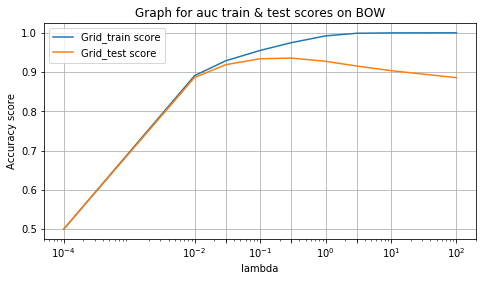

In [45]:
#graph for train scores of Grid search for all hyperparameters
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.65)

sns.lineplot(param_bow["param_C"],param_bow["mean_train_score"],label="Grid_train score")
sns.lineplot(param_bow["param_C"],param_bow["mean_test_score"],label="Grid_test score")
plt.grid()
plt.xlabel("lambda")
plt.ylabel("Accuracy score")
plt.xscale('log')
plt.xticks(c)
plt.title("Graph for auc train & test scores on BOW")
plt.show()

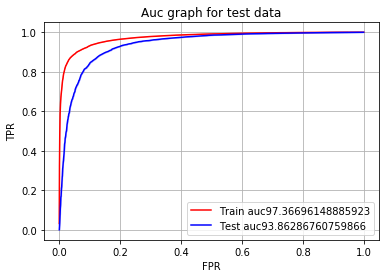

In [46]:
#fitting our model on test(unseen data) data 
LR=LogisticRegression(penalty="l1",C=best_lambda_bow,class_weight="balanced")
LR.fit(xtrain_Bow_LR,ytrain_Bow_LR)

train_fpr_bow,train_tpr_bow,threshold=roc_curve(ytrain_Bow_LR,LR.predict_proba(xtrain_Bow_LR)[:,1])
test_fpr_bow,test_tpr_bow,threshold=roc_curve(ytest_bow_LR,LR.predict_proba(xtest_bow_LR)[:,1])

#plotiing the graph for auc score of both train & test 
sns.lineplot(train_fpr_bow,train_tpr_bow,color="r",label="Train auc" + str(auc(train_fpr_bow,train_tpr_bow) * float(100)))
sns.lineplot(test_fpr_bow,test_tpr_bow,color="b",label="Test auc" + str(auc(test_fpr_bow,test_tpr_bow) * float(100)))
plt.legend()
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Auc graph for test data")
plt.show()

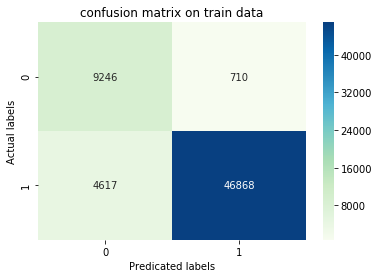

In [47]:
#confusion matrix on train data 
confusion_bow_train=confusion_matrix(ytrain_Bow_LR,LR.predict(xtrain_Bow_LR))
sns.heatmap(confusion_bow_train,annot=True,fmt="d",cmap="GnBu")
plt.title("confusion matrix on train data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

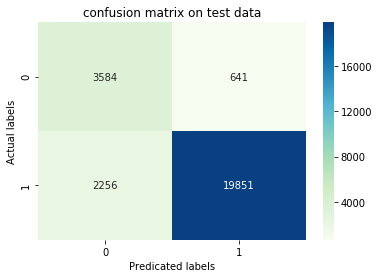

In [48]:
#confusion matrix on test data 
confusion_bow_test=confusion_matrix(ytest_bow_LR,LR.predict(xtest_bow_LR))
sns.heatmap(confusion_bow_test,annot=True,fmt="d",cmap="GnBu")
plt.title("confusion matrix on test data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [49]:
# Please write all the code with proper documentation
weight=LR.coef_
num_nonzero=np.count_nonzero(weight)
print (num_nonzero)

2764


In [50]:
#printing the sparsity
print ("sparsity on weight vector obtained using L1 regularization on BOW is {}% ".format(num_nonzero/weight.shape[1] * (100)))

sparsity on weight vector obtained using L1 regularization on BOW is 5.9976131062167735% 


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
#with L2
LR=LogisticRegression(penalty="l2",class_weight="balanced")

LR_Grid=GridSearchCV(LR,param_grid=param , cv=3, scoring='roc_auc')
LR_Bow=LR_Grid.fit(xtrain_Bow_LR,ytrain_Bow_LR)


In [52]:
print (LR_Grid.best_estimator_)
LR_Grid.best_score_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


0.9384392852010274

In [53]:
#calculating the best lambda for l2
param_bow=pd.DataFrame(LR_Grid.cv_results_).sort_values('rank_test_score')
best_lambda_bow=param_bow["param_C"].iloc[0]


lambda_values_bow=param_bow["param_C"].unique()

print ("The best lambda for bow is : {0}".format(best_lambda_bow))


The best lambda for bow is : 0.1


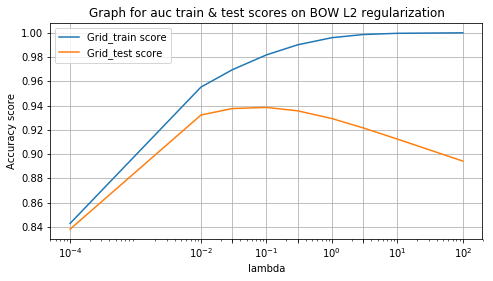

In [54]:
#graph for train scores of Grid search for all hyperparameters with L2 regularization
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.65)

sns.lineplot(param_bow["param_C"],param_bow["mean_train_score"],label="Grid_train score")
sns.lineplot(param_bow["param_C"],param_bow["mean_test_score"],label="Grid_test score")
plt.grid()
plt.xlabel("lambda")
plt.ylabel("Accuracy score")
plt.xscale('log')
plt.xticks(c)
plt.title("Graph for auc train & test scores on BOW L2 regularization")
plt.show()

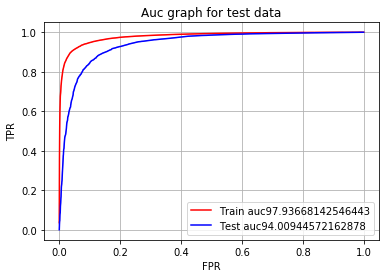

In [55]:
#fitting our model on test(unseen data) data 
LR=LogisticRegression(penalty="l2",C=best_lambda_bow,class_weight="balanced")
LR.fit(xtrain_Bow_LR,ytrain_Bow_LR)

train_fpr_bow,train_tpr_bow,threshold=roc_curve(ytrain_Bow_LR,LR.predict_proba(xtrain_Bow_LR)[:,1])
test_fpr_bow,test_tpr_bow,threshold=roc_curve(ytest_bow_LR,LR.predict_proba(xtest_bow_LR)[:,1])

#plotiing the graph for auc score of both train & test 
sns.lineplot(train_fpr_bow,train_tpr_bow,color="r",label="Train auc" + str(auc(train_fpr_bow,train_tpr_bow) * float(100)))
sns.lineplot(test_fpr_bow,test_tpr_bow,color="b",label="Test auc" + str(auc(test_fpr_bow,test_tpr_bow) * float(100)))
plt.legend()
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Auc graph for test data")
plt.show()

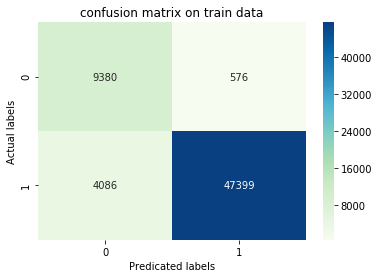

In [56]:
#confusion matrix on train data for l2 
confusion_Bow_train=confusion_matrix(ytrain_Bow_LR,LR.predict(xtrain_Bow_LR))
sns.heatmap(confusion_Bow_train,annot=True,fmt="d",cmap="GnBu")
plt.title("confusion matrix on train data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

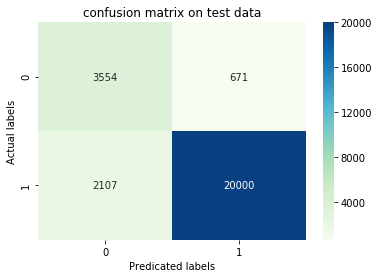

In [57]:
#confusion matrix on test data for l2 
confusion_bow_test=confusion_matrix(ytest_bow_LR,LR.predict(xtest_bow_LR))
sns.heatmap(confusion_bow_test,annot=True,fmt="d",cmap="GnBu")
plt.title("confusion matrix on test data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [0]:
#i am taking only 10k points for my perbutation testing because i have low ram and when i was generating new data set by adding a small noise to original data,
#it was always giving memory erro even i tried in google colab but there also it was thowing me session crashed error 

In [59]:

previous_weight=LR.coef_[0]
previous_weight

array([ 0.06273675,  0.01256487,  0.00814529, ...,  0.00187167,
       -0.02968413,  0.00033746])

In [0]:
#generating new data set by adding a small noise to original data 
xtrain_Bow_LR.dtype=np.float64
noisey_data=xtrain_Bow_LR[0:10000].todense() + 0.01


In [71]:
#fitting the data 
LR_again=LogisticRegression(penalty="l2",C=best_lambda_bow,class_weight="balanced")
LR_again.fit(noisey_data,ytrain_Bow_LR[0:10000])


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [0]:
new_weight=LR_again.coef_[0]

In [0]:
# Adding small esilon to weight vector to avoid division by 0
previous_weight += 10**-6
new_weight += 10**-6

In [0]:
percentage_change=abs( (previous_weight-new_weight)/(previous_weight) ) * float(100)

0th percentile is : 1.2951139119078932 
10th percentile is : 99.26918285013949 
20th percentile is : 99.93073732204707 
30th percentile is : 99.9806653020229 
40th percentile is : 99.99211742125098 
50th percentile is : 99.9961937907041 
60th percentile is : 99.99809937157394 
70th percentile is : 99.99949384052034 
80th percentile is : 100.00090632427387 
90th percentile is : 100.00380891090768 
100th percentile is : 4010.66426592103 


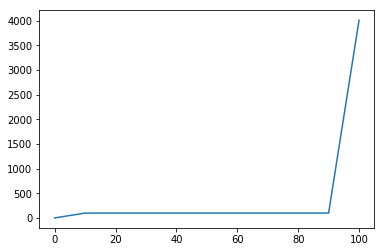

In [75]:
#plotting the percentile values on graph
for i in range(0,101,10):
    print("{0}th percentile is : {1} ".format(i,np.percentile(percentage_change,i)))
          
         
sns.lineplot(range(0,101,10),np.percentile(percentage_change,range(0,101,10)))
plt.show()

In [0]:
#if you observe above plot there is huge change between 80 to 100 .. if you look more deeply then it mostly from 90 to 100 , so same as above we can plot for 90 to 100

90th percentile is : 100.00380891090768 
91th percentile is : 100.00464521845753 
92th percentile is : 100.00581675395118 
93th percentile is : 100.00758962384545 
94th percentile is : 100.01028028777428 
95th percentile is : 100.01471622758784 
96th percentile is : 100.02245345597437 
97th percentile is : 100.04071756597418 
98th percentile is : 100.12083211382034 
99th percentile is : 100.48930213890857 
100th percentile is : 4010.66426592103 


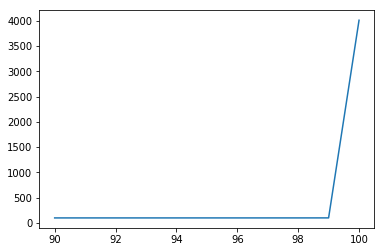

In [77]:
for i in range(90,101,1):
    print("{0}th percentile is : {1} ".format(i,np.percentile(percentage_change,i)))
          
         
sns.lineplot(range(90,101,1),np.percentile(percentage_change,range(90,101,1)))
plt.show()

In [0]:
#Again if you observe above plot there is huge change between 99 to 100 .so same as above we can plot for 99 to 100

99.0th percentile is : 100.48930213890857 
99.11111111111111th percentile is : 100.615103450938 
99.22222222222223th percentile is : 100.9103762084672 
99.33333333333333th percentile is : 101.27278539523913 
99.44444444444444th percentile is : 101.93807413529319 
99.55555555555556th percentile is : 102.99469708617549 
99.66666666666667th percentile is : 105.00056655070667 
99.77777777777777th percentile is : 113.90579652438865 
99.88888888888889th percentile is : 138.57552829337035 
100.0th percentile is : 4010.66426592103 


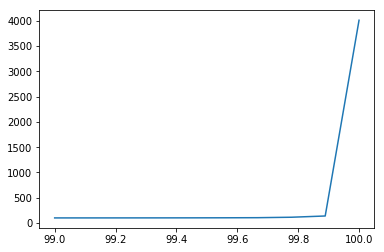

In [79]:
for i in np.linspace(99,100,10):
    print("{0}th percentile is : {1} ".format(i,np.percentile(percentage_change,i)))
          
         
sns.lineplot(np.linspace(99,100,10),np.percentile(percentage_change,np.linspace(99,100,10)))
plt.show()

In [0]:
#ploting between (between 99.90 to 100 )

99.9th percentile is : 142.37124244821786 
99.92500000000001th percentile is : 144.95671320665699 
99.95th percentile is : 206.11019903343407 
99.975th percentile is : 342.7777808507483 
100.0th percentile is : 4010.66426592103 


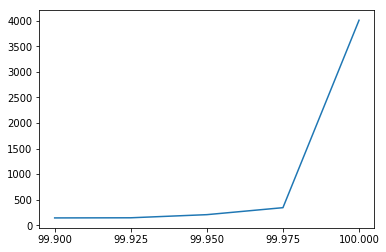

In [81]:
for i in np.linspace(99.90,100,5):
    print("{0}th percentile is : {1} ".format(i,np.percentile(percentage_change,i)))
          
         
sns.lineplot(np.linspace(99.90,100,5),np.percentile(percentage_change,np.linspace(99.90,100,5)))
plt.xticks(np.linspace(99.90,100,5))
plt.show()

In [0]:
#by looking at above we can set our threshhold at 0.25e^7 , also this can vary as we are taking ony 10000 points because computional power 

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [83]:
Pos=LR.coef_.argsort()
words=np.take(count_vect.get_feature_names(),Pos[0][-10:])
print ("Top 10 Postive feature are below  : \n")
for i in words:
  print (i)


Top 10 Postive feature are below  : 

best
pleased
wonderful
pleasantly
amazing
yummy
awesome
perfect
excellent
delicious


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [84]:
Pos=LR.coef_.argsort()
words=np.take(count_vect.get_feature_names(),Pos[0][:10])
print ("Top 10 negative feature are below  : \n")
for i in words:
  print (i)



Top 10 negative feature are below  : 

worst
disappointing
terrible
disappointment
awful
disappointed
threw
rip
horrible
unfortunately


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [90]:
#fit_transform has to happen only on train data to avoid data leakage
xtest_tfidf_LR=xtest
xtest_tfidf_LR=tf_idf_vect.transform(xtest_tfidf_LR)

#check the size of our all data set

print (xtrain_tfidf_LR.shape)
print (xtest_tfidf_LR.shape)
ytest_tfidf_LR=ytest
print (ytest_tfidf_LR.shape)
ytrain_tfidf_LR=ytrain
print (ytrain_tfidf_LR.shape)

(61441, 36229)
(26332, 36229)
(26332,)
(61441,)


In [0]:
#tunning the hyperparameter with gridsearchcv on BOW    

LR=LogisticRegression(penalty="l1",class_weight="balanced")

LR_Grid=GridSearchCV(LR,param_grid=param , cv=3, scoring='roc_auc')
LR_tfidf=LR_Grid.fit(xtrain_tfidf_LR,ytrain_tfidf_LR)


In [92]:
print (LR_Grid.best_estimator_)
LR_Grid.best_score_

LogisticRegression(C=3, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


0.9560480343336397

In [93]:
#calculating the best lambda
param_tfidf=pd.DataFrame(LR_Grid.cv_results_).sort_values('rank_test_score')
best_lambda_tfidf=param_tfidf["param_C"].iloc[0]


lambda_values_tfidf=param_tfidf["param_C"].unique()

print ("The best lambda for bow is : {0}".format(best_lambda_tfidf))


The best lambda for bow is : 3


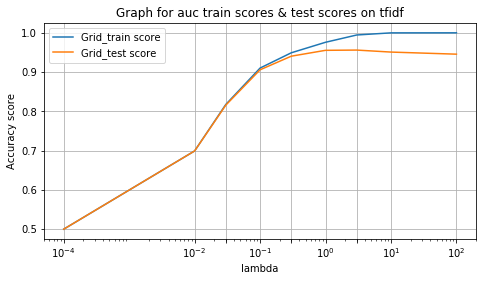

In [94]:
#graph for train scores of Grid search for all hyperparameters
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.65)

sns.lineplot(param_tfidf["param_C"],param_tfidf["mean_train_score"],label="Grid_train score")
sns.lineplot(param_tfidf["param_C"],param_tfidf["mean_test_score"],label="Grid_test score")
plt.grid()
plt.xlabel("lambda")
plt.ylabel("Accuracy score")
plt.xscale('log')
plt.xticks(c)
plt.title("Graph for auc train scores & test scores on tfidf")
plt.show()

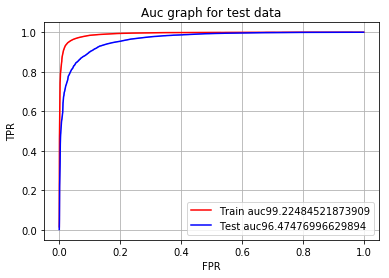

In [113]:
#fitting our model on test(unseen data) data 
LR_tfidf=LogisticRegression(C=best_lambda_tfidf)
LR_tfidf.fit(xtrain_tfidf_LR,ytrain_tfidf_LR)

train_fpr_tfidf,train_tpr_tfidf,threshold=roc_curve(ytrain_tfidf_LR,LR_tfidf.predict_proba(xtrain_tfidf_LR)[:,1])
test_fpr_tfidf,test_tpr_tfidf,threshold=roc_curve(ytest_tfidf_LR,LR_tfidf.predict_proba(xtest_tfidf_LR)[:,1])

#plotiing the graph for auc score of both train & test 
sns.lineplot(train_fpr_tfidf,train_tpr_tfidf,color="r",label="Train auc" + str(auc(train_fpr_tfidf,train_tpr_tfidf) * float(100)))
sns.lineplot(test_fpr_tfidf,test_tpr_tfidf,color="b",label="Test auc" + str(auc(test_fpr_tfidf,test_tpr_tfidf) * float(100)))
plt.legend()
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Auc graph for test data")
plt.show()

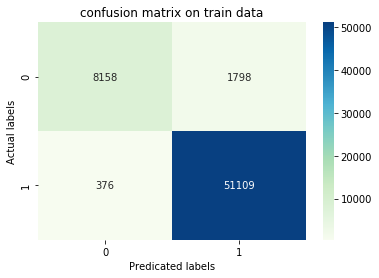

In [114]:
#confusion matrix on train data 
confusion_tfidf_train=confusion_matrix(ytrain_tfidf_LR,LR_tfidf.predict(xtrain_tfidf_LR))
sns.heatmap(confusion_tfidf_train,annot=True,fmt="d",cmap="GnBu")
plt.title("confusion matrix on train data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

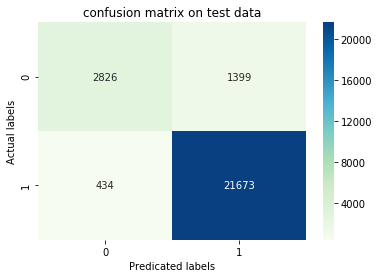

In [115]:
#confusion matrix on test data 
confusion_tfidf_test=confusion_matrix(ytest_tfidf_LR,LR_tfidf.predict(xtest_tfidf_LR))
sns.heatmap(confusion_tfidf_test,annot=True,fmt="d",cmap="GnBu")
plt.title("confusion matrix on test data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
#with L2
LR=LogisticRegression(penalty="l2",class_weight="balanced")

LR_Grid=GridSearchCV(LR,param_grid=param , cv=3, scoring='roc_auc')
LR_tfidf=LR_Grid.fit(xtrain_tfidf_LR,ytrain_tfidf_LR)




In [119]:
print (LR_Grid.best_estimator_)
LR_Grid.best_score_


LogisticRegression(C=3, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


0.9614970417822172

In [120]:
#calculating the best lambda
param_tfidf=pd.DataFrame(LR_Grid.cv_results_).sort_values('rank_test_score')
best_lambda_tfidf=param_tfidf["param_C"].iloc[0]


lambda_values_bow=param_tfidf["param_C"].unique()

print ("The best lambda for bow is : {0}".format(best_lambda_tfidf))


The best lambda for bow is : 3


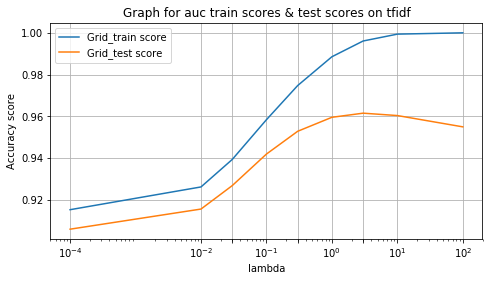

In [121]:
#graph for train scores of Grid search for all hyperparameters
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.65)

sns.lineplot(param_tfidf["param_C"],param_tfidf["mean_train_score"],label="Grid_train score")
sns.lineplot(param_tfidf["param_C"],param_tfidf["mean_test_score"],label="Grid_test score")
plt.grid()
plt.xlabel("lambda")
plt.ylabel("Accuracy score")
plt.xscale('log')
plt.xticks(c)
plt.title("Graph for auc train scores & test scores on tfidf")
plt.show()

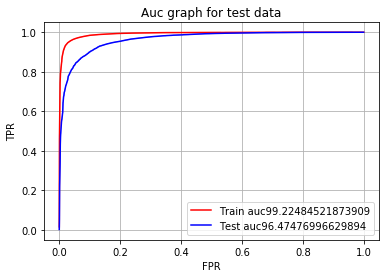

In [122]:
#fitting our model on test(unseen data) data 
LR=LogisticRegression(penalty="l2",C=best_lambda_tfidf)
LR.fit(xtrain_tfidf_LR,ytrain_tfidf_LR)

train_fpr_tfidf,train_tpr_tfidf,threshold=roc_curve(ytrain_tfidf_LR,LR.predict_proba(xtrain_tfidf_LR)[:,1])
test_fpr_tfidf,test_tpr_tfidf,threshold=roc_curve(ytest_tfidf_LR,LR.predict_proba(xtest_tfidf_LR)[:,1])

#plotiing the graph for auc score of both train & test 
sns.lineplot(train_fpr_tfidf,train_tpr_tfidf,color="r",label="Train auc" + str(auc(train_fpr_tfidf,train_tpr_tfidf) * float(100)))
sns.lineplot(test_fpr_tfidf,test_tpr_tfidf,color="b",label="Test auc" + str(auc(test_fpr_tfidf,test_tpr_tfidf) * float(100)))
plt.legend()
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Auc graph for test data")
plt.show()

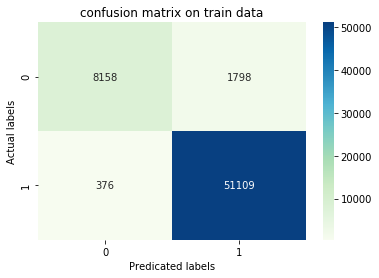

In [124]:
#confusion matrix on train data 
confusion_tfidf_test=confusion_matrix(ytrain_tfidf_LR,LR.predict(xtrain_tfidf_LR))
sns.heatmap(confusion_tfidf_test,annot=True,fmt="d",cmap="GnBu")
plt.title("confusion matrix on train data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

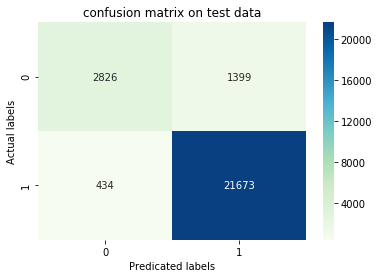

In [125]:
#confusion matrix on test data 
confusion_tfidf_test=confusion_matrix(ytest_tfidf_LR,LR.predict(xtest_tfidf_LR))
sns.heatmap(confusion_tfidf_test,annot=True,fmt="d",cmap="GnBu")
plt.title("confusion matrix on test data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [128]:
Pos=LR.coef_.argsort()
words=np.take(tf_idf_vect.get_feature_names(),Pos[0][-10:])
print ("Top 10 Postive feature are below  : \n")
for i in words:
  print (i)


Top 10 Postive feature are below  : 

love
amazing
loves
excellent
not disappointed
perfect
good
best
delicious
great


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [130]:
Pos=LR.coef_.argsort()
words=np.take(tf_idf_vect.get_feature_names(),Pos[0][:10])
print ("Top 10 negative feature are below  : \n")
for i in words:
  print (i)


Top 10 negative feature are below  : 

disappointed
worst
not good
terrible
not worth
awful
not
not recommend
disappointing
disappointment


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [138]:
#avgw2v on test data
i=0
list_of_sentance_test=[]
for sentance in xtest:
    list_of_sentance_test.append(sentance.split())
    
        
    
xtest_Avgw2v_LR = []; 
for sent in list_of_sentance_test: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    xtest_Avgw2v_LR.append(sent_vec)
print(len(xtest_Avgw2v_LR))
print(len(xtest_Avgw2v_LR[0]))

26332
50


In [142]:
#check the size of our all data set
ytest_Avgw2v_LR=ytest
ytrain_Avgw2v_LR=ytrain 
print (len(xtrain_Avgw2v_LR))
print (len(xtest_Avgw2v_LR))
print (len(ytest_Avgw2v_LR))

61441
26332
26332


In [0]:
LR=LogisticRegression(penalty="l1",class_weight="balanced")
LR_Grid=GridSearchCV(LR,param_grid=param , cv=3, scoring='roc_auc')
LR_avgw2v=LR_Grid.fit(xtrain_Avgw2v_LR,ytrain_Avgw2v_LR)

In [145]:
print (LR_Grid.best_estimator_)
LR_Grid.best_score_

LogisticRegression(C=0.3, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


0.9050796079009951

In [146]:
#calculating the best lambda
param_avgw2v=pd.DataFrame(LR_Grid.cv_results_).sort_values('rank_test_score')
best_lambda_avgw2v=param_avgw2v["param_C"].iloc[0]


lambda_values_avgw2v=param_avgw2v["param_C"].unique()

print ("The best lambda for avgw2v is : {0}".format(best_lambda_avgw2v))


The best lambda for avgw2v is : 0.3


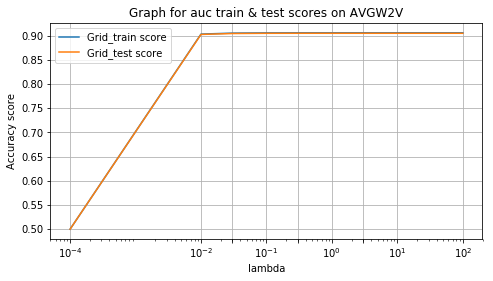

In [147]:
#graph for train scores of Grid search for all hyperparameters

plt.figure(figsize=(8,6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.65)

sns.lineplot(param_avgw2v["param_C"],param_avgw2v["mean_train_score"],label="Grid_train score")
sns.lineplot(param_avgw2v["param_C"],param_avgw2v["mean_test_score"],label="Grid_test score")

plt.grid()
plt.xlabel("lambda")
plt.ylabel("Accuracy score")
plt.xscale('log')
plt.xticks(c)
plt.title("Graph for auc train & test scores on AVGW2V")
plt.show()

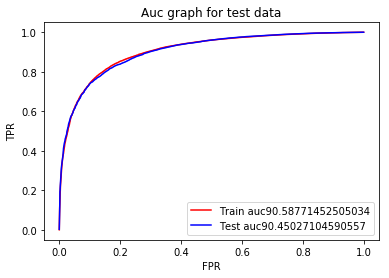

In [148]:
#fitting our model on test(unseen data) data 
LR=LogisticRegression(penalty="l1",class_weight="balanced")
LR.fit(xtrain_Avgw2v_LR,ytrain_Avgw2v_LR)

train_fpr_avgw2v,train_tpr_avgw2v,threshold=roc_curve(ytrain_Avgw2v_LR,LR.predict_proba(xtrain_Avgw2v_LR)[:,1])
test_fpr_avgw2v,test_tpr_avgw2v,threshold=roc_curve(ytest_Avgw2v_LR,LR.predict_proba(xtest_Avgw2v_LR)[:,1])

#plotiing the graph for auc score of both train & test 
sns.lineplot(train_fpr_avgw2v,train_tpr_avgw2v,color="r",label="Train auc" + str(auc(train_fpr_avgw2v,train_tpr_avgw2v) * float(100)))
sns.lineplot(test_fpr_avgw2v,test_tpr_avgw2v,color="b",label="Test auc" + str(auc(test_fpr_avgw2v,test_tpr_avgw2v) * float(100)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Auc graph for test data")
plt.show()

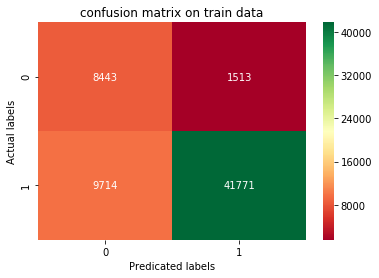

In [149]:
#confusion matrix on test data 
confusion_avgw2v_train=confusion_matrix(ytrain_Avgw2v_LR,LR.predict(xtrain_Avgw2v_LR))
sns.heatmap(confusion_avgw2v_train,annot=True,fmt="d",cmap="RdYlGn")
plt.title("confusion matrix on train data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

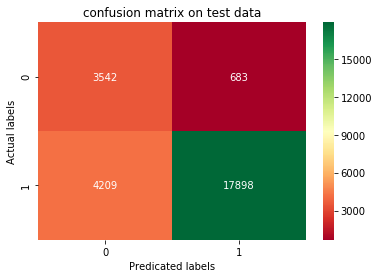

In [150]:
#confusion matrix on test data 
confusion_avgw2v_test=confusion_matrix(ytest_Avgw2v_LR,LR.predict(xtest_Avgw2v_LR))
sns.heatmap(confusion_avgw2v_test,annot=True,fmt="d",cmap="RdYlGn")
plt.title("confusion matrix on test data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [0]:
LR=LogisticRegression(penalty="l2",class_weight="balanced")
LR_Grid=GridSearchCV(LR,param_grid=param , cv=3, scoring='roc_auc')
LR_avgw2v=LR_Grid.fit(xtrain_Avgw2v_LR,ytrain_Avgw2v_LR)

In [158]:
print (LR_Grid.best_estimator_)
LR_Grid.best_score_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


0.9050887259374575

In [159]:
#calculating the best lambda
param_avgw2v=pd.DataFrame(LR_Grid.cv_results_).sort_values('rank_test_score')
best_lambda_avgw2v=param_avgw2v["param_C"].iloc[0]


lambda_values_avgw2v=param_avgw2v["param_C"].unique()

print ("The best lambda for avgw2v is : {0}".format(best_lambda_avgw2v))


The best lambda for avgw2v is : 0.1


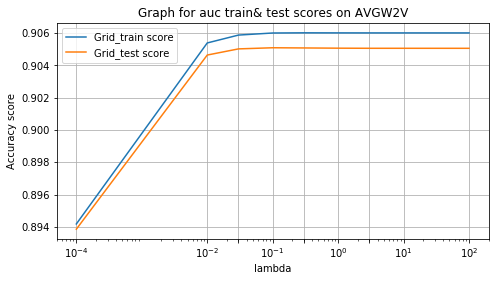

In [160]:
#graph for train scores of Grid search for all hyperparameters

plt.figure(figsize=(8,6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.65)

sns.lineplot(param_avgw2v["param_C"],param_avgw2v["mean_train_score"],label="Grid_train score")
sns.lineplot(param_avgw2v["param_C"],param_avgw2v["mean_test_score"],label="Grid_test score")
plt.grid()
plt.xlabel("lambda")
plt.ylabel("Accuracy score")
plt.xscale('log')
plt.xticks(c)
plt.title("Graph for auc train& test scores on AVGW2V")
plt.show()

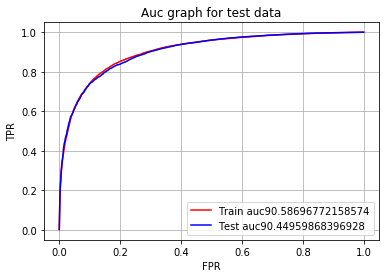

In [161]:
#fitting our model on test(unseen data) data 
LR=LogisticRegression(penalty="l2",class_weight="balanced")
LR.fit(xtrain_Avgw2v_LR,ytrain_Avgw2v_LR)

train_fpr_avgw2v,train_tpr_avgw2v,threshold=roc_curve(ytrain_Avgw2v_LR,LR.predict_proba(xtrain_Avgw2v_LR)[:,1])
test_fpr_avgw2v,test_tpr_avgw2v,threshold=roc_curve(ytest_Avgw2v_LR,LR.predict_proba(xtest_Avgw2v_LR)[:,1])

#plotiing the graph for auc score of both train & test 
sns.lineplot(train_fpr_avgw2v,train_tpr_avgw2v,color="r",label="Train auc" + str(auc(train_fpr_avgw2v,train_tpr_avgw2v) * float(100)))
sns.lineplot(test_fpr_avgw2v,test_tpr_avgw2v,color="b",label="Test auc" + str(auc(test_fpr_avgw2v,test_tpr_avgw2v) * float(100)))
plt.legend()
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Auc graph for test data")
plt.show()

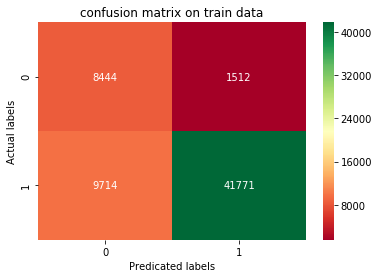

In [163]:
#confusion matrix on train data 
confusion_avgw2v_train=confusion_matrix(ytrain_Avgw2v_LR,LR.predict(xtrain_Avgw2v_LR))
sns.heatmap(confusion_avgw2v_train,annot=True,fmt="d",cmap="RdYlGn")
plt.title("confusion matrix on train data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

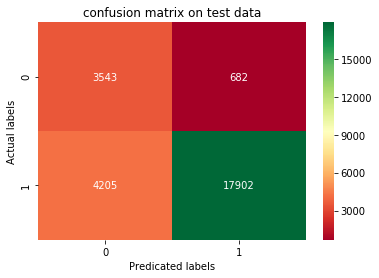

In [162]:
#confusion matrix on test data 
confusion_avgw2v_test=confusion_matrix(ytest_Avgw2v_LR,LR.predict(xtest_Avgw2v_LR))
sns.heatmap(confusion_avgw2v_test,annot=True,fmt="d",cmap="RdYlGn")
plt.title("confusion matrix on test data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# TF-IDF weighted Word2Vec on test 
tfidf_feat = model.get_feature_names() 
xtest_tfidfw2v_LR = []; 
row=0;

for sent in list_of_sentance_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    xtest_tfidfw2v_LR.append(sent_vec)
    row += 1

In [180]:
#check the size of our all data set

print (len(xtrain_tfidfw2v_LR))
print (len(xtest_tfidfw2v_LR))
ytest_tfidfw2v_LR=ytest
print (len(ytest_tfidfw2v_LR))
ytrain_tfidfw2v_LR=ytrain
print (ytrain_tfidfw2v_LR.shape)

61441
26332
26332
(61441,)


In [0]:
LR=LogisticRegression(penalty="l2",class_weight="balanced")
LR_Grid=GridSearchCV(LR,param_grid=param , cv=3, scoring='roc_auc')
LR_avgw2v=LR_Grid.fit(xtrain_tfidfw2v_LR,ytrain_tfidfw2v_LR)

In [182]:
print (LR_Grid.best_estimator_)
LR_Grid.best_score_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


0.8819833028959781

In [183]:
#calculating the best lambda
param_tfidfw2v=pd.DataFrame(LR_Grid.cv_results_).sort_values('rank_test_score')
best_lambda_tfidfw2v=param_tfidfw2v["param_C"].iloc[0]


lambda_values_tfidfw2v=param_tfidfw2v["param_C"].unique()

print ("The best lambda for avgw2v is : {0}".format(best_lambda_tfidfw2v))


The best lambda for avgw2v is : 0.1


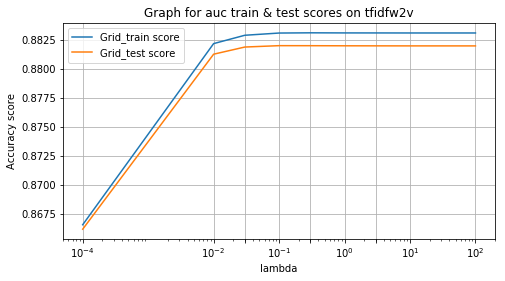

In [184]:
#graph for train scores of Grid search for all hyperparameters

plt.figure(figsize=(8,6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.65)

sns.lineplot(param_tfidfw2v["param_C"],param_tfidfw2v["mean_train_score"],label="Grid_train score")
sns.lineplot(param_tfidfw2v["param_C"],param_tfidfw2v["mean_test_score"],label="Grid_test score")
plt.grid()
plt.xlabel("lambda")
plt.ylabel("Accuracy score")
plt.xscale('log')
plt.xticks(c)
plt.title("Graph for auc train & test scores on tfidfw2v")
plt.show()

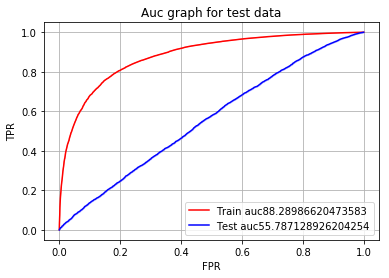

In [185]:
#fitting our model on test(unseen data) data 
LR=LogisticRegression(penalty="l1",C=best_lambda_tfidfw2v,class_weight="balanced")
LR.fit(xtrain_tfidfw2v_LR,ytrain_tfidfw2v_LR)

train_fpr_tfidfw2v,train_tpr_tfidfw2v,threshold=roc_curve(ytrain_tfidfw2v_LR,LR.predict_proba(xtrain_tfidfw2v_LR)[:,1])
test_fpr_tfidfw2v,test_tpr_tfidfw2v,threshold=roc_curve(ytest_tfidfw2v_LR,LR.predict_proba(xtest_tfidfw2v_LR)[:,1])

#plotiing the graph for auc score of both train & test 
sns.lineplot(train_fpr_tfidfw2v,train_tpr_tfidfw2v,color="r",label="Train auc" + str(auc(train_fpr_tfidfw2v,train_tpr_tfidfw2v) * float(100)))
sns.lineplot(test_fpr_tfidfw2v,test_tpr_tfidfw2v,color="b",label="Test auc" + str(auc(test_fpr_tfidfw2v,test_tpr_tfidfw2v) * float(100)))
plt.legend()
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Auc graph for test data")
plt.show()

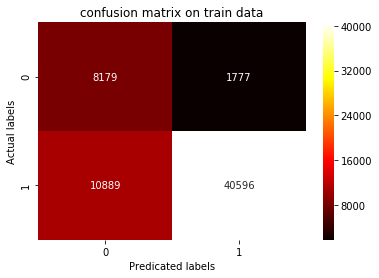

In [186]:
#confusion matrix on train data 
confusion_tfidfw2v_train=confusion_matrix(ytrain_tfidfw2v_LR,LR.predict(xtrain_tfidfw2v_LR))
sns.heatmap(confusion_tfidfw2v_train,annot=True,fmt="d",cmap='hot')
plt.title("confusion matrix on train data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

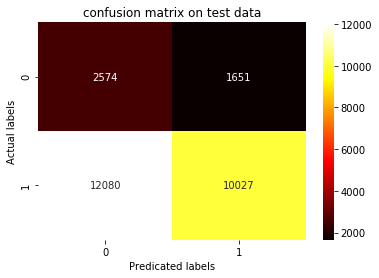

In [187]:
#confusion matrix on test data 
confusion_tfidfw2v_test=confusion_matrix(ytest_tfidfw2v_LR,LR.predict(xtest_tfidfw2v_LR))
sns.heatmap(confusion_tfidfw2v_test,annot=True,fmt="d",cmap='hot')
plt.title("confusion matrix on test data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
LR=LogisticRegression(penalty="l2",class_weight="balanced")
LR_Grid=GridSearchCV(LR,param_grid=param , cv=3, scoring='roc_auc')
LR_avgw2v=LR_Grid.fit(xtrain_avgw2v_LR,ytrain_avgw2v_LR)

In [189]:
print (LR_Grid.best_estimator_)
LR_Grid.best_score_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


0.9050887259374575

In [190]:
#calculating the best lambda
param_tfidfw2v=pd.DataFrame(LR_Grid.cv_results_).sort_values('rank_test_score')
best_lambda_tfidfw2v=param_tfidfw2v["param_C"].iloc[0]


lambda_values_tfidfw2v=param_tfidfw2v["param_C"].unique()

print ("The best lambda for tfidfw2v is : {0}".format(best_lambda_tfidfw2v))


The best lambda for tfidfw2v is : 0.1


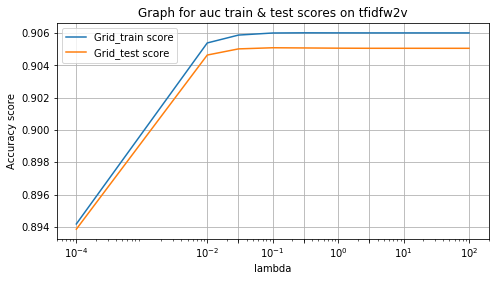

In [191]:
#graph for train scores of Grid search for all hyperparameters

plt.figure(figsize=(8,6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.65)

sns.lineplot(param_tfidfw2v["param_C"],param_tfidfw2v["mean_train_score"],label="Grid_train score")
sns.lineplot(param_tfidfw2v["param_C"],param_tfidfw2v["mean_test_score"],label="Grid_test score")
plt.grid()
plt.xlabel("lambda")
plt.ylabel("Accuracy score")
plt.xscale('log')
plt.xticks(c)
plt.title("Graph for auc train & test scores on tfidfw2v")
plt.show()

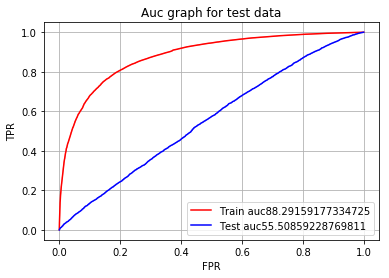

In [192]:
#fitting our model on test(unseen data) data 
LR=LogisticRegression(penalty="l2",C=best_lambda_tfidfw2v,class_weight="balanced")
LR.fit(xtrain_tfidfw2v_LR,ytrain_tfidfw2v_LR)

train_fpr_tfidfw2v,train_tpr_tfidfw2v,threshold=roc_curve(ytrain_tfidfw2v_LR,LR.predict_proba(xtrain_tfidfw2v_LR)[:,1])
test_fpr_tfidfw2v,test_tpr_tfidfw2v,threshold=roc_curve(ytest_tfidfw2v_LR,LR.predict_proba(xtest_tfidfw2v_LR)[:,1])

#plotiing the graph for auc score of both train & test 
sns.lineplot(train_fpr_tfidfw2v,train_tpr_tfidfw2v,color="r",label="Train auc" + str(auc(train_fpr_tfidfw2v,train_tpr_tfidfw2v) * float(100)))
sns.lineplot(test_fpr_tfidfw2v,test_tpr_tfidfw2v,color="b",label="Test auc" + str(auc(test_fpr_tfidfw2v,test_tpr_tfidfw2v) * float(100)))
plt.legend()
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Auc graph for test data")
plt.show()

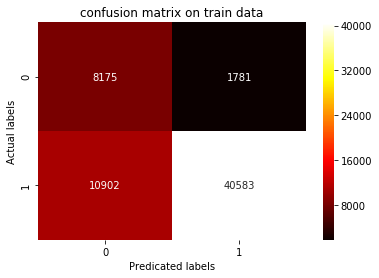

In [193]:
#confusion matrix on train data 
confusion_tfidfw2v_train=confusion_matrix(ytrain_tfidfw2v_LR,LR.predict(xtrain_tfidfw2v_LR))
sns.heatmap(confusion_tfidfw2v_train,annot=True,fmt="d",cmap='hot')
plt.title("confusion matrix on train data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

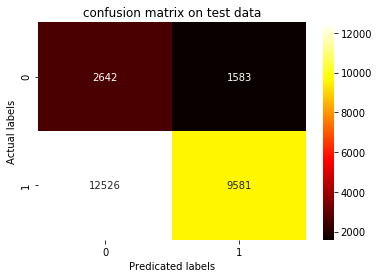

In [194]:
#confusion matrix on test data 
confusion_tfidfw2v_test=confusion_matrix(ytest_tfidfw2v_LR,LR.predict(xtest_tfidfw2v_LR))
sns.heatmap(confusion_tfidfw2v_test,annot=True,fmt="d",cmap='hot')
plt.title("confusion matrix on test data")
plt.xlabel("Predicated labels")
plt.ylabel("Actual labels")
plt.show()

# [6] Conclusions

In [195]:
#conclusions
conculsion=PrettyTable()
conculsion.field_names=["Model","best lambda","Test_Auc"]
conculsion.add_row(["Bow",best_lambda_bow,auc(test_fpr_bow,test_tpr_bow) * float(100)])
conculsion.add_row(["Tfidf",best_lambda_tfidf,auc(test_fpr_tfidf,test_tpr_tfidf) * float(100)])
conculsion.add_row(["Avgw2v",best_lambda_avgw2v,auc(test_fpr_avgw2v,test_tpr_avgw2v) * float(100)])
conculsion.add_row(["Tfidf-W2v",best_lambda_tfidfw2v,auc(test_fpr_tfidfw2v,test_tpr_tfidfw2v) * float(100)])
print (conculsion)

+-----------+-------------+-------------------+
|   Model   | best lambda |      Test_Auc     |
+-----------+-------------+-------------------+
|    Bow    |    0.0001   |        50.0       |
|   Tfidf   |      3      | 96.47476996629894 |
|   Avgw2v  |     0.1     | 90.44959868396928 |
| Tfidf-W2v |     0.1     | 55.50859228769811 |
+-----------+-------------+-------------------+
